In [1]:
% cd ~/Documents/GitHub/cs231n-adni/new_code

/Users/elissali/Documents/GitHub/cs231n-adni/new_code


In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import os
import utils
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
import multiprocessing
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [3]:
import data, model, interpretation, utils, vis_utils

torch.Size([32, 1])


In [4]:
train_data = np.load("train_aug.npy")
val_data = np.load("val_aug.npy")
test_data = np.load("test_aug.npy")
train_label = np.load("train_label_aug.npy")
val_label = np.load("val_label_aug.npy")
test_label = np.load("test_label_aug.npy")

train_data = np.reshape(train_data, (2048, 1, 64, 64, 64))
val_data = np.reshape(val_data, (512, 1, 64, 64, 64))
test_data = np.reshape(test_data, (512, 1, 64, 64, 64))

# Visualisation

In [5]:
train_data[0].shape

(1, 64, 64, 64)

In [6]:
train_data = np.reshape(train_data, (2048, 1, 64, 64, 64))      # want channels first!

In [7]:
train_ex = torch.from_numpy(train_data[0])

In [8]:
train_ex = torch.squeeze(train_ex)

In [9]:
train_ex.shape

torch.Size([64, 64, 64])

tensor(-1.0938, dtype=torch.float64) tensor(2.8692, dtype=torch.float64) None None


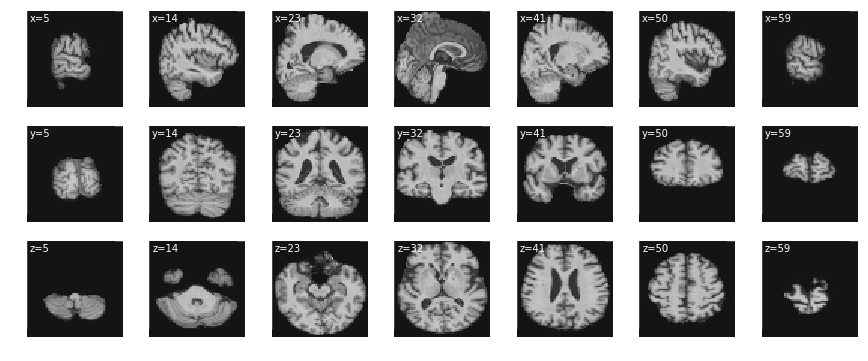

In [10]:
vis_utils.plot_slices(train_ex)

tensor(-1.2525, dtype=torch.float64) tensor(2.4545, dtype=torch.float64) None None


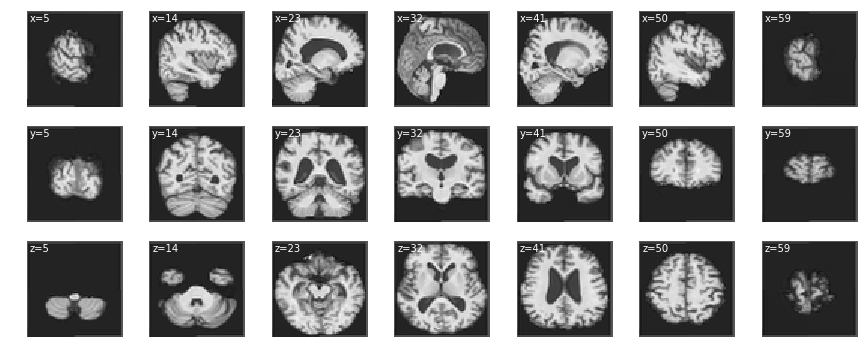

In [11]:
train_ex_2000 = torch.squeeze(torch.from_numpy(train_data[2000]))
vis_utils.plot_slices(train_ex_2000)

In [12]:
net = model.SingleTimestep3DCNN(in_num_ch=1, img_size=(64,64,64), inter_num_ch=16, fc_num_ch=16,
                                conv_act='relu', fc_act='tanh').to(torch.device('cpu'))

In [13]:
# net.load_state_dict(torch.load('../ckpt/2020_5_5_21_44/model_best.pth.tar')['model'])

In [14]:
net.load_state_dict(torch.load('../ckpt/2020_5_13_1_30/epoch004.pth.tar')['model'])

<All keys matched successfully>

In [15]:
# for item in net.state_dict():
#     print(item)

# for item in torch.load('../ckpt/2020_5_5_21_44/model_best.pth.tar')['model']:
#     print(item)

In [16]:
net.eval();

In [17]:
train_data[2000][0].shape
train_data[0][0].shape

(64, 64, 64)

# Sensitivity Analysis

In [18]:
relevance_map_backprop = interpretation.sensitivity_analysis(net, train_data[0], cuda=False, verbose=True)

output:  tensor([[-4.0040]], grad_fn=<AddmmBackward>)
Image was classified as 0 with probability 0.01791638880968094
one hot output:  tensor([[[1.],
         [0.]]])


tensor(-1.0938, dtype=torch.float64) tensor(2.8692, dtype=torch.float64) 9.913492e-10 0.00526706877257683


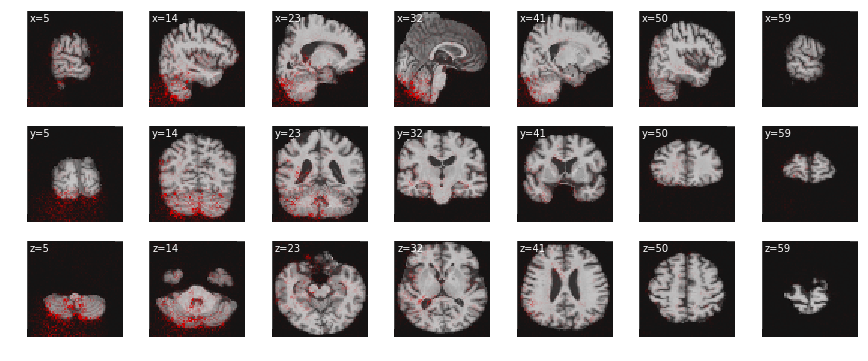

In [26]:
vis_utils.plot_slices(train_ex, num_slices = 7, overlay=relevance_map_backprop[0], 
                  overlay_vmax=np.percentile(relevance_map_backprop, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

In [20]:
relevance_map_backprop = interpretation.sensitivity_analysis(net, train_data[2000], cuda=False, verbose=True)

output:  tensor([[3.1999]], grad_fn=<AddmmBackward>)
Image was classified as 1 with probability 0.9608314037322998
one hot output:  tensor([[[0.],
         [1.]]])


-1.2525044640745717 2.4545196225244514 9.913492e-10 0.00526706877257683


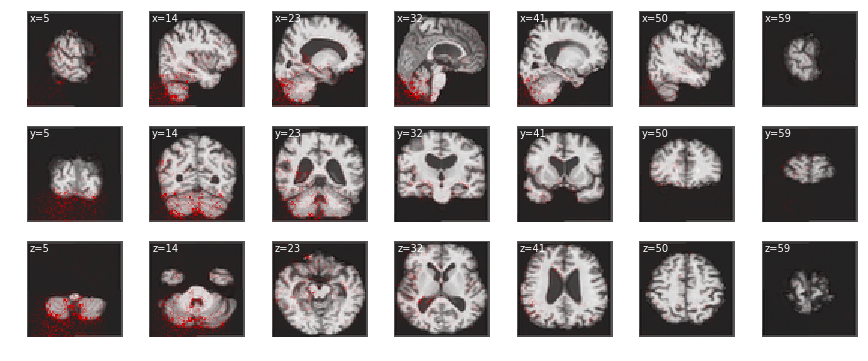

In [21]:
vis_utils.plot_slices(train_data[2000][0], overlay=relevance_map_backprop[0], 
                  overlay_vmax=np.percentile(relevance_map_backprop, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

# Guided Backprop

In [27]:
relevance_map_guided = interpretation.guided_backprop(net, train_data[0], cuda=False, verbose=True)

output:  tensor([[-4.0040]], grad_fn=<AddmmBackward>)
Image was classified as 0 with probability 0.01791638880968094
one hot output:  tensor([[[1.],
         [0.]]])
Removing 0 hook(s)


tensor(-1.0938, dtype=torch.float64) tensor(2.8692, dtype=torch.float64) 3.3969627e-10 0.002243255654349929


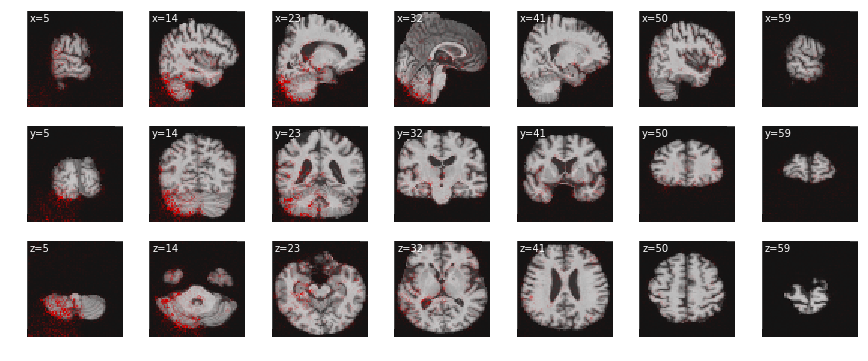

In [28]:
vis_utils.plot_slices(train_ex, overlay=relevance_map_guided[0], 
                  overlay_vmax=np.percentile(relevance_map_guided, 99.9))

# Occlusion

In [29]:
relevance_map_occlusion = interpretation.occlusion(net, train_data[0], size=10, stride=5, cuda=False, resize=True, verbose=True)

Image was classified as 0 with probability tensor(0.0179)


tensor(-1.0938, dtype=torch.float64) tensor(2.8692, dtype=torch.float64) 0.0 0.011346076615154743


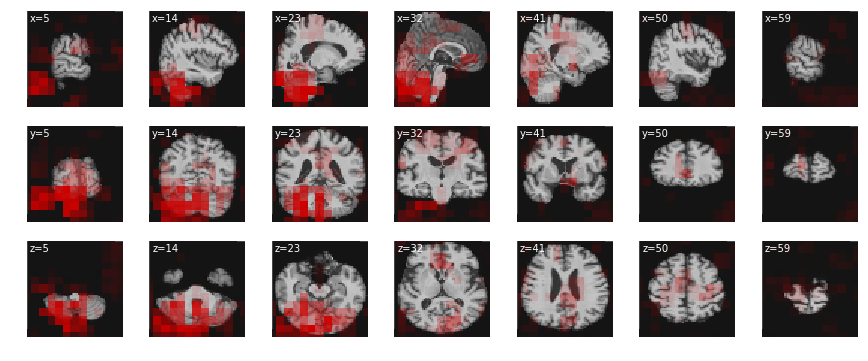

In [30]:
vis_utils.plot_slices(train_ex, overlay=relevance_map_occlusion, 
                      overlay_cmap = vis_utils.alpha_to_red_cmap)

In [ ]:
# Plot occlusion patch on image.
occluded_image = train_data[0][0][:, 30, :].copy()
size = 20
occluded_image[10:10+size, 20:20+size] = 0
plt.imshow(occluded_image, cmap='gray')
plt.axis('off')

In [31]:
relevance_map_occlusion = interpretation.occlusion(net, train_data[2000], size=10, stride=5, cuda=False, resize=True, verbose=True)

Image was classified as 0 with probability tensor(0.9608)


-1.2525044640745717 2.4545196225244514 0.0 0.10233479738235474


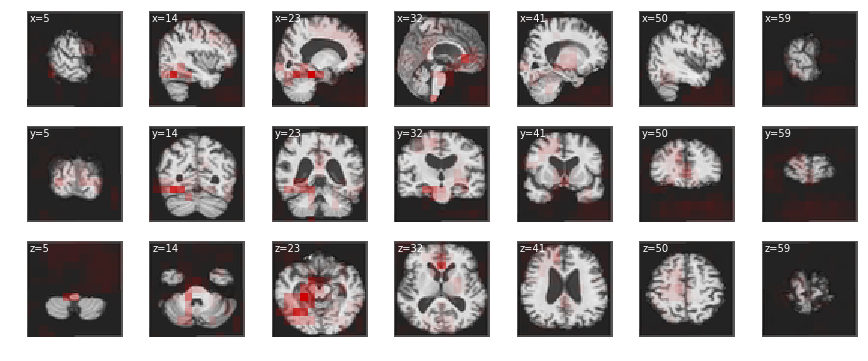

In [34]:
vis_utils.plot_slices(train_data[2000][0], overlay=relevance_map_occlusion, 
                      overlay_cmap = vis_utils.alpha_to_red_cmap)